**How to identify position players on a given date?**

Problem:
<br>
In daily fantasy baseball, a participant sets up their team against another player of their league. Some position players are stars and should play nearly all the time, but often a position is shared between other players on your roster. How do you choose which platooning player to start (especially if there is a limited sample size for the batter facing that pitcher)?

Strategy:
<br>
- Focus on features of the batter (e.g. historical batting average) and pitcher (e.g. historical ERA, WHIP) to predict whether the batter would output a hit (or HR, single, double, etc.) in a given batter-pitcher at-bat matchup.

- If you choose a given date (e.g. May 1), you know the starting pitcher a batter would face. Use statistical data to make a prediction on how well that player will do against the pitcher as a guide for a decision. If the matchup for a particular batter-pitcher is small, find similar players to serve as a guide. (Similar players can be found by using Erdos score.)

- How do I know if my strategy is improved over other models? Look at which player one would choose from a simple player ranking.

- Validation: Historical data

This notebook was created within my "insight" virtual environment.

**Inputs and outputs**

*Version 1:*
- Input: Two players under consideration for one position.
- Output: Player recommendation for that position with a predicted score.

*Version 2:*
- Input: A participant's player roster (e.g. 20 players)
- Output: A recommended lineup.

Order of features of product to incorporate: (still to be determined)

0.  Try a simple model where each at-bat batter-pitcher matchup is simply its own row and selected features are done.
1.	Roster’s “basic” baseball statistics from 2018 season? Or 50 games (including previous season) - (minimum viable product level)
2.	Specific matchup against that pitcher - “basic” baseball statistics
3.	Roster’s statcast statistics from last 50 games (including previous season)
4.	Use of player similarity
5.	Weather, park effects, team defense, night/day, lineup order
6.	Limit to more recent performance (last 7 games)
7.	Computer vision?

Similar idea
https://community.fangraphs.com/the-outcome-machine-predicting-at-bats-before-they-happen/



EDA, do HR over time and by date for each player

Use batted ball characteristics as a feature of player and pitcher (launch angle average, launch speed average)




**Product pitch**

I'm creating a fantasy baseball application that suggests players on a given day. Fantasy baseball has over 11 million participants with the winners of leagues collecting entry fees and host platforms receiving a commission. The projected market for fantasy baseball in 2020 is over 8 billion dollars. A participant's success depends in part on daily player selection. For player selection, participants must rely on their own research or use a site's recommendation, which uses black-box algorithms behind pay walls. I'm developing an alternative algorithm to assist in player selection to save participants time and expose the important features in player performance prediction.

# Ideas

- Predicting the next pitch, based on count

- Will hit happen based on pitch count

- Or use all info for at-bat and then do backwards selection 

- 2018 season as true talent average, then update with each at bat
- Use Bayesian 

- EDA  - plot someone's hits over game-dates as a time series

- Look at the player's last 100 hits 



# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [2]:
# Web/database stuff
# import urllib.request
# import xml.etree.ElementTree as ET
# from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [3]:
# Check versioning
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
print('sklearn: ', sklearn.__version__)

print('psycopg2: ', psycopg2.__version__)
print('sqlalchemy: ', sqlalchemy.__version__)
print('sqlalchemy_utils: ', sqlalchemy_utils.__version__)
print('multiprocess: ', multiprocess.__version__)

numpy:  1.17.4
pandas:  0.25.3
matplotlib:  3.1.1
seaborn:  0.9.0
sklearn:  0.22
psycopg2:  2.8.4 (dt dec pq3 ext lo64)
sqlalchemy:  1.3.11
sqlalchemy_utils:  0.36.1
multiprocess:  0.70.9


In [4]:
# Code formatting with Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [5]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup

<IPython.core.display.Javascript object>

# Build a database

In [7]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

<IPython.core.display.Javascript object>

In [8]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


<IPython.core.display.Javascript object>

In [9]:
## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


<IPython.core.display.Javascript object>

## Statcast data to database

In [ ]:
# This is done, but note it's out of order

# date_list = [
#     ("2019-03-20", "2019-09-29"),
#     ("2018-03-29", "2018-10-01"),
#     ("2017-04-02", "2017-10-01"),
# ]

# Above gave **2,174,906** pitch-by-pitch results in the database

#     ("2016-04-03", "2016-10-02"),   # didn't get
#     ("2015-04-05", "2015-10-04"),   # didn't get 


# for i, date_pair in enumerate(date_list):
#     if i < 1:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="replace")
#         print(date_pair, "replace mode")
#     else:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="append")
#         print(date_pair, "append mode")

In [11]:
# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

<IPython.core.display.Javascript object>

See other notebook for more info



# Input batter and date

In [229]:
# Make a query to get player - batter matchup

# Enter key_mlbam (Manny Machado shown below)
pid_of_interest = 592518

# Enter key_mlbam (Ty France shown below)
# pid_of_interest = 664034

date_of_interest = "'2019-09-09'"  # Note internal single quotes

sql_query = (
    """
SELECT * FROM statcast 
JOIN player_id ON statcast.batter=player_id.key_mlbam 
WHERE statcast.batter= 
"""
    + str(pid_of_interest)
    + """
AND statcast.game_date<=
"""
    + str(date_of_interest)
    + """
AND statcast.events IS NOT NULL 
ORDER BY statcast.game_date DESC, statcast.inning DESC, statcast.outs_when_up 
LIMIT 501;
"""
)


# "Sample query"

# pitchers and batters
# sql_query = """
# (SELECT * FROM statcast WHERE "game_date" > '2019-01-01'
# AND "events" IS NOT NULL);
# """

df_sc_events = pd.read_sql_query(sql_query, con)
df_sc_events.drop(["level_0", "index"], axis=1, inplace=True)  # Clean up df

<IPython.core.display.Javascript object>

## Contingencies

1. What if player has day off? or no game is scheduled?
2. What if player or pitcher doesn't have minimum nback at-bats?
3. What if player doesn't have minimum nback at-bats against same or opposite handedness?

**Quora answer on number of plate appearances**
https://www.quora.com/How-many-at-bats-does-the-average-MLB-player-go-through-per-year

One direction to go with is how many PA wpild a player accumulate if theu were to play every day, and not rest. That would be around 725. Though that total is not really an average as few players exceed such a total each year.

A second number would be how many plate appearances bases on normal rest during a season if a player never was injured, about 145-150 games for position players other then the catcher and 110 to 115 for catchers. Those totals would be around 650 and 450 respectively.

Yet another way to answer this would be the number of PA by all position players on a roster that were supposed to be starters, but may receive less playing time due to injury or a team developing, trading for or discovering a better player. That would probably be closer to 400.

You could also thing about all position players on a team including bench players, if we include them our total now is closer to 200-250.

Yet another way to look at this is to include all players on the roster including pitcher who may notbat intentionally. Include them and tour total is closer to 100-120.

In [230]:
df_sc_events.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0


<IPython.core.display.Javascript object>

In [231]:
df_sc_events.shape

(501, 97)

<IPython.core.display.Javascript object>

In [232]:
df_sc_events.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,if_fielding_alignment,of_fielding_alignment,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,Standard,Standard,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0


<IPython.core.display.Javascript object>

In [233]:
# Encode on-base events, including walks
ob_list = ["walk", "single", "double", "triple", "home_run"]
df_sc_events["event_code"] = 0
df_sc_events.loc[df_sc_events["events"].isin(ob_list), "event_code"] = 1

<IPython.core.display.Javascript object>

In [234]:
n_back_PA = 100

# Sum of on-base events - critical that order matters! (should be addressed above)
    # rolling was close, but needed to tweak
df_sc_events["num_events_sum_nback"] = df_sc_events["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1]

# Percent of on-base events (overall)
df_sc_events["prop_events_nback"] = df_sc_events["num_events_sum_nback"] / n_back_PA

# Percent of on-base events against handedness of pitcher
for i in df_sc_events.index:
    p_throws = df_sc_events["p_throws"].iloc[i]
    df_sc_events_pt_throw = df_sc_events[df_sc_events["p_throws"] == batter_stance]
    n_pt_events = df_sc_events_pt_throw["event_code"].iloc[i : i + n_back_PA].sum()
    df_sc_events.loc[i, "num_events_sum_nback_pt"] = n_pt_events
    df_sc_events.loc[i, "prop_events_sum_nback_pt"] = n_pt_events / n_back_PA
    
# df_sc_events.loc[: n_back_PA + 1, "event_code"]


<IPython.core.display.Javascript object>

In [235]:
df_sc_events.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,event_code,num_events_sum_nback,prop_events_nback,num_events_sum_nback_pt,prop_events_sum_nback_pt
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,machm001,machama01,11493,2012.0,2019.0,1,33.0,0.33,29.0,0.29
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,machm001,machama01,11493,2012.0,2019.0,1,32.0,0.32,29.0,0.29
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,machm001,machama01,11493,2012.0,2019.0,0,32.0,0.32,28.0,0.28
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,machm001,machama01,11493,2012.0,2019.0,1,32.0,0.32,28.0,0.28
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,machm001,machama01,11493,2012.0,2019.0,1,31.0,0.31,27.0,0.27


<IPython.core.display.Javascript object>

In [237]:
df_sc_events["game_type"].unique()

array(['R'], dtype=object)

<IPython.core.display.Javascript object>

In [236]:
df_sc_events.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description',
       ...
       'key_retro', 'key_bbref', 'key_fangraphs', 'mlb_played_first',
       'mlb_played_last', 'event_code', 'num_events_sum_nback',
       'prop_events_nback', 'num_events_sum_nback_pt',
       'prop_events_sum_nback_pt'],
      dtype='object', length=102)

<IPython.core.display.Javascript object>

In [312]:
col4model = ["event_code", "p_throws", "prop_events_nback", "prop_events_sum_nback_pt"]

m_size = 100
df_sc_events_4model = df_sc_events[col4model].copy()
df_sc_events_4model_overall = df_sc_events_4model.loc[:m_size]

<IPython.core.display.Javascript object>

In [313]:
df_sc_events_4model_overall.shape

(101, 4)

<IPython.core.display.Javascript object>

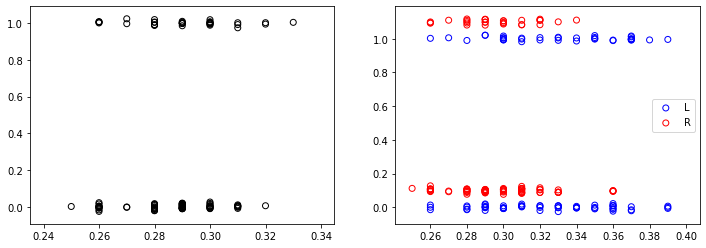

<IPython.core.display.Javascript object>

In [314]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(
    df_sc_events_4model_overall["prop_events_nback"],
    df_sc_events_4model_overall["event_code"]
    + np.random.normal(0, 0.01, len(df_sc_events_4model_overall)),
    facecolors="none",
    edgecolors="black",
)

for hand in ["L", "R"]:
    if hand == "L":
        df_temp = df_sc_events_4model[df_sc_events_4model["p_throws"] == hand].iloc[
            :m_size, :
        ]
        ax2.scatter(
            df_temp["prop_events_nback"],
            df_temp["event_code"] + np.random.normal(0, 0.01, len(df_temp)),
            facecolors="none",
            edgecolors="blue",
            label=hand,
        )
    else:
        df_temp = df_sc_events_4model[df_sc_events_4model["p_throws"] == hand].iloc[
            :m_size, :
        ]
        ax2.scatter(
            df_temp["prop_events_nback"],
            df_temp["event_code"] + 0.1 + np.random.normal(0, 0.01, len(df_temp)),
            facecolors="none",
            edgecolors="red",
            label=hand,
        )
ax2.legend()

In [315]:
df_sc_events_4model_overall.head()

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,1,R,0.33,0.29
1,1,R,0.32,0.29
2,0,R,0.32,0.28
3,1,R,0.32,0.28
4,1,R,0.31,0.27


<IPython.core.display.Javascript object>

In [316]:
df_sc_events_4model_overall["p_throws"] = (
    df_sc_events_4model_overall["p_throws"].replace({"L": 0, "R": 1}).copy()
)

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<IPython.core.display.Javascript object>

In [317]:
df_sc_events_4model_overall.head()

,event_code,p_throws,prop_events_nback,prop_events_sum_nback_pt
0,1,1,0.33,0.29
1,1,1,0.32,0.29
2,0,1,0.32,0.28
3,1,1,0.32,0.28
4,1,1,0.31,0.27


<IPython.core.display.Javascript object>

# Logistic regression

In [278]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

<IPython.core.display.Javascript object>

In [318]:
y = df_sc_events_4model_overall["event_code"]
X = df_sc_events_4model_overall.iloc[:, 1::]

<IPython.core.display.Javascript object>

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<IPython.core.display.Javascript object>

In [320]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70, 3) (31, 3) (70,) (31,)


<IPython.core.display.Javascript object>

In [321]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<IPython.core.display.Javascript object>

In [322]:
y_pred = log_reg.predict(X_test)

<IPython.core.display.Javascript object>

In [323]:
y_prob = log_reg.predict_proba(X_test)[:, 1]

<IPython.core.display.Javascript object>

In [324]:
df_temp = pd.DataFrame({"test": y_test, "pred": y_pred, "prob": y_prob})
df_temp

,test,pred,prob
5,0,0,0.335620
55,0,0,0.335580
31,0,0,0.336508
70,1,0,0.335039
24,0,0,0.336277
62,1,0,0.336006
34,1,0,0.363835
87,1,0,0.334808
33,0,0,0.363835
79,0,0,0.361470


<IPython.core.display.Javascript object>

In [325]:
df_temp["pred"].sum()

0

<IPython.core.display.Javascript object>

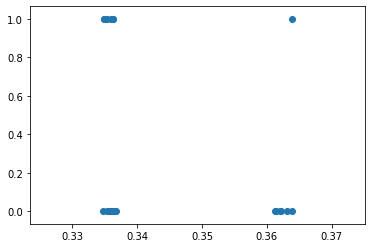

<IPython.core.display.Javascript object>

In [326]:
f, ax1 = plt.subplots()
ax1.scatter(df_temp["prob"], df_temp["test"])

In [293]:
df_temp["pred"].sum()

0

<IPython.core.display.Javascript object>

In [227]:
df_sc_events.loc[
    0:50,
    [
        "event_code",
        "p_throws",
        "num_events_sum_nback",
        "prop_events_nback",
        "num_events_sum_nback_pt",
        "prop_events_sum_nback_pt",
    ],
]

,event_code,p_throws,num_events_sum_nback,prop_events_nback,num_events_sum_nback_pt,prop_events_sum_nback_pt
0,1,R,5.0,0.5,5.0,0.5
1,1,R,4.0,0.4,4.0,0.4
2,0,R,3.0,0.3,3.0,0.3
3,1,R,3.0,0.3,3.0,0.3
4,1,R,2.0,0.2,2.0,0.2
5,0,R,1.0,0.1,1.0,0.1
6,0,R,1.0,0.1,1.0,0.1
7,0,R,2.0,0.2,2.0,0.2
8,0,R,3.0,0.3,3.0,0.3
9,1,R,3.0,0.3,3.0,0.3


<IPython.core.display.Javascript object>

In [218]:
for i in df_sc_events.index:
    p_throws = df_sc_events["p_throws"].iloc[i]
    df_sc_events_pt_throw = df_sc_events[df_sc_events["p_throws"] == batter_stance]
    n_pt_events = df_sc_events_pt_throw["event_code"].iloc[i : i + n_back_PA].sum()
    df_sc_events.loc[i, "num_events_sum_nback_pt"] = n_pt_events
    df_sc_events.loc[i, "prop_events_sum_nback_pt"] = n_pt_events / n_back_PA
#     print(
#         i,
#         df_sc_events_pt_throw["game_date"].iloc[i],
#         df_sc_events["num_events_sum_nback"].iloc[i],
#         df_sc_events_pt_throw["event_code"].iloc[i],
#         "end: ",
#         df_sc_events_pt_throw["event_code"].iloc[i + n_back_PA + 1],
#         p_throws,
#         n_pt_events,
#     )

0 2019-09-09 00:00:00 33.0 1 end:  0 R 29
1 2019-09-09 00:00:00 32.0 1 end:  0 R 29
2 2019-09-09 00:00:00 32.0 0 end:  0 R 28
3 2019-09-08 00:00:00 32.0 1 end:  1 R 28
4 2019-09-08 00:00:00 31.0 1 end:  0 R 27
5 2019-09-08 00:00:00 30.0 0 end:  0 R 27
6 2019-09-08 00:00:00 30.0 0 end:  0 R 27
7 2019-09-08 00:00:00 30.0 0 end:  0 R 27
8 2019-09-07 00:00:00 31.0 0 end:  0 R 27
9 2019-09-07 00:00:00 31.0 1 end:  0 R 27
10 2019-09-07 00:00:00 31.0 0 end:  0 R 26
11 2019-09-07 00:00:00 31.0 0 end:  1 R 26
12 2019-09-06 00:00:00 31.0 0 end:  1 R 26
13 2019-09-06 00:00:00 31.0 0 end:  1 R 27
14 2019-09-06 00:00:00 31.0 0 end:  1 R 28
15 2019-09-06 00:00:00 31.0 0 end:  1 R 29
16 2019-09-04 00:00:00 31.0 1 end:  0 R 30
17 2019-09-04 00:00:00 30.0 1 end:  0 R 30
18 2019-09-04 00:00:00 29.0 0 end:  0 R 29
19 2019-09-04 00:00:00 29.0 0 end:  1 R 29
20 2019-09-03 00:00:00 29.0 0 end:  0 R 29
21 2019-09-03 00:00:00 29.0 0 end:  0 R 30
22 2019-09-03 00:00:00 29.0 0 end:  0 R 30
23 2019-09-03 00:00:0

204 2019-06-22 00:00:00 34.0 1 end:  1 R 36
205 2019-06-22 00:00:00 33.0 0 end:  0 L 35
206 2019-06-21 00:00:00 33.0 1 end:  0 R 36
207 2019-06-21 00:00:00 34.0 0 end:  0 R 35
208 2019-06-21 00:00:00 35.0 1 end:  0 R 35
209 2019-06-21 00:00:00 34.0 0 end:  0 R 34
210 2019-06-19 00:00:00 35.0 0 end:  0 R 34
211 2019-06-19 00:00:00 36.0 1 end:  0 R 34
212 2019-06-19 00:00:00 37.0 0 end:  0 R 33
213 2019-06-19 00:00:00 37.0 1 end:  1 R 33
214 2019-06-19 00:00:00 37.0 0 end:  1 R 32
215 2019-06-18 00:00:00 37.0 0 end:  0 R 33
216 2019-06-18 00:00:00 37.0 1 end:  0 R 34
217 2019-06-18 00:00:00 38.0 1 end:  0 R 33
218 2019-06-18 00:00:00 38.0 0 end:  0 R 32
219 2019-06-17 00:00:00 38.0 0 end:  1 R 32
220 2019-06-17 00:00:00 38.0 0 end:  1 R 32
221 2019-06-17 00:00:00 37.0 1 end:  0 L 33
222 2019-06-17 00:00:00 37.0 1 end:  1 L 33
223 2019-06-16 00:00:00 37.0 1 end:  0 L 32
224 2019-06-16 00:00:00 37.0 0 end:  1 L 32
225 2019-06-16 00:00:00 38.0 0 end:  1 R 32
226 2019-06-16 00:00:00 38.0 0 e

IndexError: single positional indexer is out-of-bounds

<IPython.core.display.Javascript object>

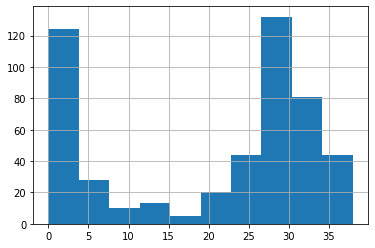

<IPython.core.display.Javascript object>

In [214]:
df_sc_events.loc[:, "num_events_sum_nback_pt"].hist()

In [194]:
for i in df_sc_events.index:
    batter_stance = df_sc_events["stand"].iloc[i]
    df_sc_events_cp_throw = df_sc_events[df_sc_events["p_throws"] == batter_stance]
    n_cp_events = df_sc_events_cp_throw["event_code"].iloc[i : i + 100].sum()
    print(
        i,
        df_sc_events_cp_throw["game_date"].iloc[i],
        df_sc_events_cp_throw["event_code"].iloc[i],
        p_throw,
        n_cp_events,
    )

#     print(df_sc_events_cp_throw["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1].iloc[
#     0:100)
# ]

0 2019-09-09 00:00:00 1 R 29
1 2019-09-09 00:00:00 1 R 29
2 2019-09-09 00:00:00 0 R 28
3 2019-09-08 00:00:00 1 R 28
4 2019-09-08 00:00:00 1 R 27
5 2019-09-08 00:00:00 0 R 27
6 2019-09-08 00:00:00 0 R 27
7 2019-09-08 00:00:00 0 R 27
8 2019-09-07 00:00:00 0 R 27
9 2019-09-07 00:00:00 1 R 27
10 2019-09-07 00:00:00 0 R 26
11 2019-09-07 00:00:00 0 R 26
12 2019-09-06 00:00:00 0 R 26
13 2019-09-06 00:00:00 0 R 27
14 2019-09-06 00:00:00 0 R 28
15 2019-09-06 00:00:00 0 R 29
16 2019-09-04 00:00:00 1 R 30
17 2019-09-04 00:00:00 1 R 30
18 2019-09-04 00:00:00 0 R 29
19 2019-09-04 00:00:00 0 R 29
20 2019-09-03 00:00:00 0 R 29
21 2019-09-03 00:00:00 0 R 30
22 2019-09-03 00:00:00 0 R 30
23 2019-09-03 00:00:00 0 R 30
24 2019-09-02 00:00:00 0 R 30
25 2019-09-02 00:00:00 1 R 30
26 2019-09-02 00:00:00 0 R 29
27 2019-09-02 00:00:00 0 R 30
28 2019-09-01 00:00:00 1 R 31
29 2019-09-01 00:00:00 0 R 30
30 2019-09-01 00:00:00 0 R 31
31 2019-09-01 00:00:00 0 R 32
32 2019-08-31 00:00:00 0 R 32
33 2019-08-31 00:00:

276 2019-06-01 00:00:00 0 R 26
277 2019-05-31 00:00:00 0 R 27
278 2019-05-31 00:00:00 0 R 27
279 2019-05-29 00:00:00 0 R 27
280 2019-05-28 00:00:00 0 R 27
281 2019-05-28 00:00:00 1 R 27
282 2019-05-28 00:00:00 0 R 26
283 2019-05-28 00:00:00 0 R 27
284 2019-05-28 00:00:00 1 R 28
285 2019-05-27 00:00:00 0 R 27
286 2019-05-27 00:00:00 0 R 27
287 2019-05-27 00:00:00 0 R 27
288 2019-05-26 00:00:00 0 R 27
289 2019-05-26 00:00:00 1 R 28
290 2019-05-26 00:00:00 0 R 27
291 2019-05-26 00:00:00 0 R 27
292 2019-05-25 00:00:00 0 R 27
293 2019-05-25 00:00:00 0 R 27
294 2019-05-25 00:00:00 0 R 27
295 2019-05-24 00:00:00 1 R 27
296 2019-05-24 00:00:00 0 R 26
297 2019-05-24 00:00:00 1 R 26
298 2019-05-24 00:00:00 1 R 25
299 2019-05-22 00:00:00 0 R 24
300 2019-05-22 00:00:00 0 R 24
301 2019-05-22 00:00:00 0 R 24
302 2019-05-21 00:00:00 1 R 24
303 2019-05-21 00:00:00 1 R 23
304 2019-05-21 00:00:00 0 R 22
305 2019-05-20 00:00:00 1 R 22
306 2019-05-20 00:00:00 0 R 21
307 2019-05-20 00:00:00 0 R 21
308 2019

IndexError: single positional indexer is out-of-bounds

<IPython.core.display.Javascript object>

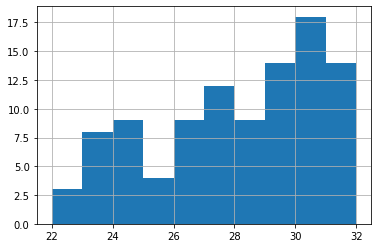

<IPython.core.display.Javascript object>

In [209]:
df_sc_events["num_events_sum_nback_cp"].iloc[0:100].hist()

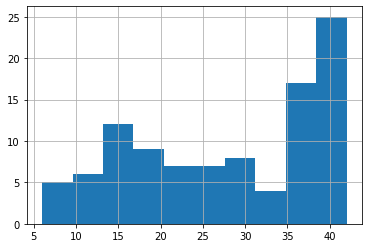

<IPython.core.display.Javascript object>

In [208]:
df_sc_events["num_events_sum_nback_tp"].iloc[0:100].hist()

In [187]:
df_sc_events_cp_throw["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1]

0      29.0
1      29.0
2      28.0
3      28.0
4      27.0
       ... 
496     NaN
497     NaN
498     NaN
499     NaN
500     NaN
Name: event_code, Length: 390, dtype: float64

<IPython.core.display.Javascript object>

500

<IPython.core.display.Javascript object>

In [185]:
df_sc_events_cp_throw

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,event_code,event_code_sum_nback,num_events_sum_nback,prop_events_sum_nback,prop_events_nback
0,SI,2019-09-09,84.7,-2.3591,5.8620,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,machm001,machama01,11493,2012.0,2019.0,1,33.0,33.0,0.33,0.33
1,SI,2019-09-09,85.4,-2.4186,5.8800,Kyle Hendricks,592518.0,543294.0,single,hit_into_play_no_out,...,machm001,machama01,11493,2012.0,2019.0,1,32.0,32.0,0.32,0.32
2,CU,2019-09-09,71.5,-2.2610,5.9986,Kyle Hendricks,592518.0,543294.0,field_out,hit_into_play,...,machm001,machama01,11493,2012.0,2019.0,0,32.0,32.0,0.32,0.32
3,SI,2019-09-08,92.4,-1.2178,6.0300,Jesus Tinoco,592518.0,622786.0,walk,ball,...,machm001,machama01,11493,2012.0,2019.0,1,32.0,32.0,0.32,0.32
4,FC,2019-09-08,93.2,-2.9951,6.0254,Bryan Shaw,592518.0,543766.0,walk,ball,...,machm001,machama01,11493,2012.0,2019.0,1,31.0,31.0,0.31,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,SL,2019-04-26,86.0,-3.4961,5.1076,Max Scherzer,592518.0,453286.0,strikeout,swinging_strike,...,machm001,machama01,11493,2012.0,2019.0,0,NaN,NaN,NaN,NaN
497,SL,2019-04-24,84.2,-2.5172,5.8355,Felix Hernandez,592518.0,433587.0,field_out,hit_into_play,...,machm001,machama01,11493,2012.0,2019.0,0,NaN,NaN,NaN,NaN
498,SI,2019-04-24,90.3,-2.1757,5.8358,Felix Hernandez,592518.0,433587.0,field_out,hit_into_play,...,machm001,machama01,11493,2012.0,2019.0,0,NaN,NaN,NaN,NaN
499,SI,2019-04-24,88.9,-2.2221,5.8318,Felix Hernandez,592518.0,433587.0,single,hit_into_play_no_out,...,machm001,machama01,11493,2012.0,2019.0,1,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

In [160]:
p_throw = df_sc_events["p_throws"].iloc[0]

<IPython.core.display.Javascript object>

In [166]:
df_sc_events_cp_throw = df_sc_events[df_sc_events["p_throws"] == p_throw]

<IPython.core.display.Javascript object>

In [176]:
df_sc_events_cp_throw.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            490, 491, 492, 494, 495, 496, 497, 498, 499, 500],
           dtype='int64', length=390)

<IPython.core.display.Javascript object>

In [179]:
# df_sc_events_cp_throw["num_events_sum_nback"] =
df_sc_events_cp_throw["event_code"].iloc[::-1].rolling(n_back_PA).sum().iloc[::-1].iloc[
    0:100
]

0      29.0
1      29.0
2      28.0
3      28.0
4      27.0
       ... 
129    26.0
132    26.0
133    25.0
134    26.0
135    27.0
Name: event_code, Length: 100, dtype: float64

<IPython.core.display.Javascript object>

In [156]:
df_sc_events["p_throws"].iloc[0]

'R'

<IPython.core.display.Javascript object>

In [152]:
df_sc_events[["event_code", "num_events_sum_nback", "prop_events_nback"]]

,event_code,num_events_sum_nback,prop_events_nback
0,1,33.0,0.33
1,1,32.0,0.32
2,0,32.0,0.32
3,1,32.0,0.32
4,1,31.0,0.31
...,...,...,...
496,0,NaN,NaN
497,0,NaN,NaN
498,0,NaN,NaN
499,1,NaN,NaN


<IPython.core.display.Javascript object>

Text(0, 0.5, 'prop_events_nback')

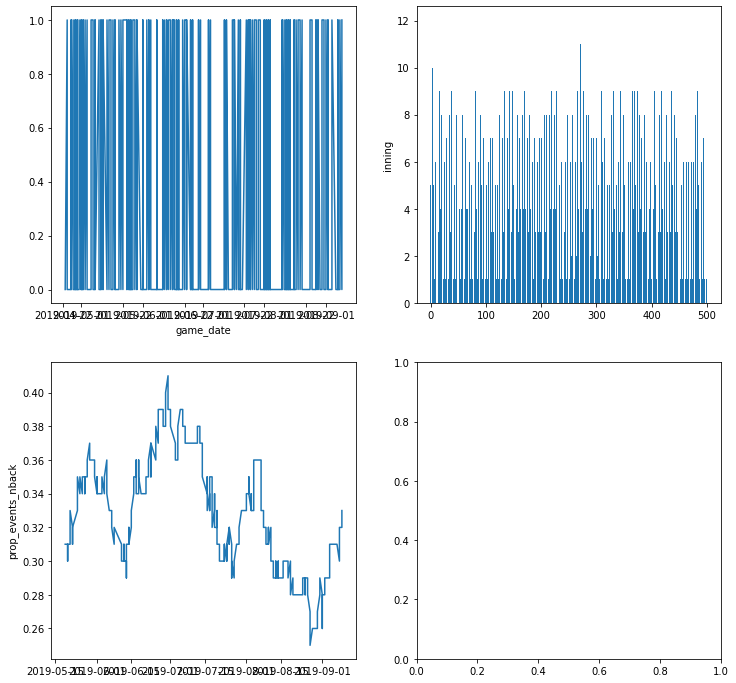

<IPython.core.display.Javascript object>

In [155]:
# Sanity checking that df is in order
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
ax1.plot(df_sc_events["game_date"], df_sc_events["event_code"])
ax1.set_xlabel("game_date")
# ax1.set_xticklabels(df_sc_events["game_date"], rotation=45)

ax2.bar(df_sc_events.index, df_sc_events["inning"])
ax2.set_ylabel("inning")

# Rolling average
ax3.plot(df_sc_events["game_date"], df_sc_events["prop_events_nback"])
ax3.set_ylabel("prop_events_nback")


# ax2.bar(df_sc_events.index, df_sc_events["inning"])
# ax2.set_ylabel("inning")


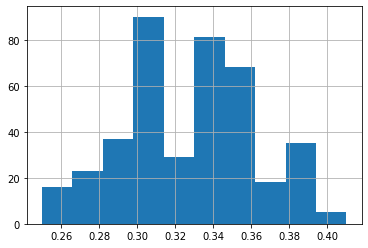

<IPython.core.display.Javascript object>

In [154]:
df_sc_events["prop_events_nback"].hist()

In [113]:
df_sc_events[["game_date", "inning", "event_code", "event_code_sum_nback"]]

,game_date,inning,event_code,event_code_sum_nback
0,2019-09-09,5.0,1,NaN
1,2019-09-09,4.0,1,2.0
2,2019-09-09,1.0,0,2.0
3,2019-09-08,10.0,1,2.0
4,2019-09-08,7.0,1,NaN
...,...,...,...,...
96,2019-08-13,7.0,1,NaN
97,2019-08-13,4.0,0,NaN
98,2019-08-13,2.0,1,NaN
99,2019-08-13,1.0,0,NaN


<IPython.core.display.Javascript object>

In [57]:
df_sc_events["event_code"].head(10)

0    1
1    0
2    1
3    1
4    0
5    0
6    0
7    1
8    0
9    0
Name: event_code, dtype: int64

<IPython.core.display.Javascript object>

1     16.0
2     16.0
3     16.0
4     15.0
5     15.0
6     15.0
7     15.0
8     14.0
9     14.0
10    15.0
11    15.0
12    15.0
13    16.0
14    16.0
15    17.0
16    17.0
17    17.0
18    17.0
19    17.0
20    16.0
21    16.0
22    17.0
23    18.0
24    18.0
25    18.0
26    18.0
27    18.0
28    18.0
29    19.0
30    18.0
31    17.0
32    17.0
33    18.0
34    18.0
35    18.0
36    17.0
37    16.0
38    16.0
39    16.0
40    16.0
41    17.0
42    16.0
43    16.0
44    16.0
45    16.0
46    16.0
47    16.0
48    17.0
49    17.0
50    16.0
Name: event_code, dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
batter_events2remove = ['caught_stealing_2b']

df_sc_events["events"]

In [40]:
df_sc_events["description"].unique()

array(['hit_into_play_no_out', 'hit_into_play', 'ball', 'swinging_strike',
       'hit_into_play_score', 'swinging_strike_blocked', 'called_strike',
       'foul', 'blocked_ball', 'foul_tip'], dtype=object)

<IPython.core.display.Javascript object>

In [46]:
df_sc_events.loc[df_sc_events["events"] == "caught_stealing_2b", "game_pk"]

54    566341.0
Name: game_pk, dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
# Limit this to events of player's outcome (not caught stealing, foul, etc.)

In [36]:
[print(col) for col in df_sc_events.columns]

level_0
index
pitch_type
game_date
release_speed
release_pos_x
release_pos_z
player_name
batter
pitcher
events
description
spin_dir
spin_rate_deprecated
break_angle_deprecated
break_length_deprecated
zone
des
game_type
stand
p_throws
home_team
away_team
type
hit_location
bb_type
balls
strikes
game_year
pfx_x
pfx_z
plate_x
plate_z
on_3b
on_2b
on_1b
outs_when_up
inning
inning_topbot
hc_x
hc_y
tfs_deprecated
tfs_zulu_deprecated
fielder_2
umpire
sv_id
vx0
vy0
vz0
ax
ay
az
sz_top
sz_bot
hit_distance_sc
launch_speed
launch_angle
effective_speed
release_spin_rate
release_extension
game_pk
pitcher.1
fielder_2.1
fielder_3
fielder_4
fielder_5
fielder_6
fielder_7
fielder_8
fielder_9
release_pos_y
estimated_ba_using_speedangle
estimated_woba_using_speedangle
woba_value
woba_denom
babip_value
iso_value
launch_speed_angle
at_bat_number
pitch_number
pitch_name
home_score
away_score
bat_score
fld_score
post_away_score
post_home_score
post_bat_score
post_fld_score
if_fielding_alignment
of_fielding_alig

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

<IPython.core.display.Javascript object>

# Feature engineering

Build metrics for predictions based on 100 previous at-bats for both pitcher and hitter